In [1]:
import numpy as np
import visualkeras as vk 
import pandas as pd
import seaborn as sn


from keras import Model
from keras_unet_collection import models

from matplotlib import pyplot as plt
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Input, Conv2DTranspose, concatenate

In [2]:
train_data = np.load("../datasets/A_Z Handwritten Data/train_data.npy")
test_data = np.load("../datasets/A_Z Handwritten Data/test_data.npy")
train_labels = np.load("../datasets/A_Z Handwritten Data/train_labels.npy")
test_labels = np.load("../datasets/A_Z Handwritten Data/test_labels.npy")

In [3]:
'''
model = models.unet_2d(
    input_size=(train_data.shape),
    filter_num=[16,32],
    n_labels=2,
    stack_num_down=2, 
    stack_num_up=2,
    output_activation='Softmax',
    batch_norm=False,
    pool='max',
    unpool=False,
    name='unet'
)
'''

"\nmodel = models.unet_2d(\n    input_size=(train_data.shape),\n    filter_num=[16,32],\n    n_labels=2,\n    stack_num_down=2, \n    stack_num_up=2,\n    output_activation='Softmax',\n    batch_norm=False,\n    pool='max',\n    unpool=False,\n    name='unet'\n)\n"

In [4]:
train_data.shape[1:]

(28, 28, 1)

In [5]:
## STAGE 2 UNET

inputs = Input(train_data.shape[1:])

conv1 = Conv2D(filters=16, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same') (inputs)
conv1 = Dropout(rate=0.1) (conv1)
conv1 = Conv2D(filters=16, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same') (conv1)
maxpool1 = MaxPool2D(pool_size=2) (conv1)

conv2 = Conv2D(filters=32, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same') (maxpool1)
conv2 = Dropout(rate=0.1) (conv2)
conv2 = Conv2D(filters=32, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same') (conv2)
maxpool2 = MaxPool2D(pool_size=2) (conv2)

conv3 = Conv2D(filters=64, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same') (maxpool2)
conv3 = Dropout(rate=0.1) (conv3)
conv3 = Conv2D(filters=64, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same') (conv3)


upconv4 = Conv2DTranspose(filters=32, kernel_size=2, strides=2, padding='same') (conv3)
upconv4 = concatenate(inputs=[upconv4, conv2])
conv4 = Conv2D(filters=32, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same') (upconv4)
conv4 = Dropout(rate=0.1) (conv4)
conv4 = Conv2D(filters=32, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same') (conv4)

upconv5 = Conv2DTranspose(filters=16, kernel_size=2, strides=2, padding='same') (conv4)
upconv5 = concatenate(inputs=[upconv5, conv1])
conv5 = Conv2D(filters=16, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same') (upconv5)
conv5 = Dropout(rate=0.1) (conv5)
conv5 = Conv2D(filters=16, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same') (conv5)


maxpool3 = MaxPool2D(pool_size=2) (conv5)

outputs = Flatten() (maxpool3)
outputs = Dense(64, activation='relu') (outputs)
outputs = Dense(128, activation='relu') (outputs)
outputs = Dense(26, activation='softmax') (outputs)


model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy') #loss="categorical_crossentropy" loss='binary_crossentropy'
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 16)   160         ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 28, 28, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 28, 28, 16)   2320        ['dropout[0][0]']                
                                                                                              

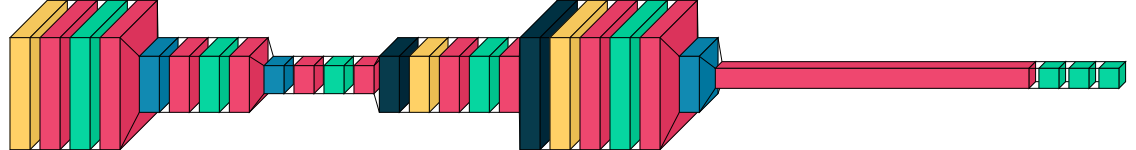

In [6]:
vk.layered_view(model)

In [7]:
best_loss_checkpoint = ModelCheckpoint(
    filepath="../datasets/A_Z Handwritten Data/models/unet2-arct/best_loss_model.h5",
    monitor="loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min"
)

best_val_loss_checkpoint = ModelCheckpoint(
    filepath="../datasets/A_Z Handwritten Data/models/unet2-arct/best_val_loss_model.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min"
)

In [8]:
history = model.fit(
    train_data,
    train_labels,
    validation_data=(test_data, test_labels), 
    epochs=10, 
    batch_size=200, 
    callbacks=[best_loss_checkpoint, best_val_loss_checkpoint]
)

Epoch 1/10
1490/1490 [==============================] - 35s 21ms/step - loss: 0.1990 - accuracy: 0.9442 - val_loss: 0.0665 - val_accuracy: 0.9819
Epoch 2/10
1490/1490 [==============================] - 30s 20ms/step - loss: 0.0634 - accuracy: 0.9820 - val_loss: 0.0574 - val_accuracy: 0.9843
Epoch 3/10
1490/1490 [==============================] - 31s 21ms/step - loss: 0.0501 - accuracy: 0.9855 - val_loss: 0.0427 - val_accuracy: 0.9881
Epoch 4/10
1490/1490 [==============================] - 32s 21ms/step - loss: 0.0426 - accuracy: 0.9874 - val_loss: 0.0421 - val_accuracy: 0.9880
Epoch 5/10
1490/1490 [==============================] - 31s 21ms/step - loss: 0.0373 - accuracy: 0.9888 - val_loss: 0.0401 - val_accuracy: 0.9883
Epoch 6/10
1490/1490 [==============================] - 31s 21ms/step - loss: 0.0321 - accuracy: 0.9903 - val_loss: 0.0365 - val_accuracy: 0.9897
Epoch 7/10
1490/1490 [==============================] - 32s 21ms/step - loss: 0.0298 - accuracy: 0.9908 - val_loss: 0.0371 -

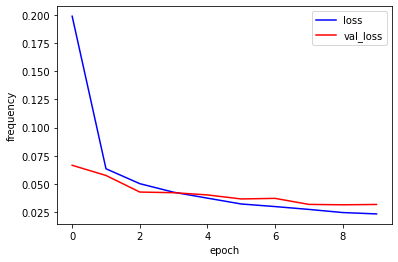

In [9]:
plt.plot(history.history["loss"], 'b', label="loss")
plt.plot(history.history["val_loss"], 'r', label="val_loss")
plt.xlabel("epoch")
plt.ylabel("frequency")
plt.legend()
plt.show()

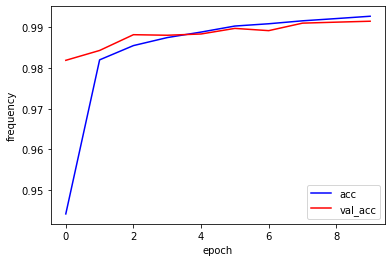

In [10]:
plt.plot(history.history["accuracy"], 'b', label="acc")
plt.plot(history.history["val_accuracy"], 'r', label="val_acc")
plt.xlabel("epoch")
plt.ylabel("frequency")
plt.legend()
plt.show()

In [11]:
model.load_weights("../datasets/A_Z Handwritten Data/models/unet2-arct/best_val_loss_model.h5")

loss, acc = model.evaluate(test_data, test_labels)
print('accuracy: {:5.4f}%'.format(100 * acc))
print('val_loss: {:5.4f}%'.format(100 * loss))

2328/2328 [==============================] - 11s 5ms/step - loss: 0.0314 - accuracy: 0.9912
accuracy: 99.1220%
val_loss: 3.1369%


In [12]:
predictions = model.predict(test_data)

In [13]:
confusion = confusion_matrix(
    np.argmax(test_labels, axis=1),
    np.argmax(predictions, axis=1)
)

<AxesSubplot:xlabel='predicted', ylabel='actual'>

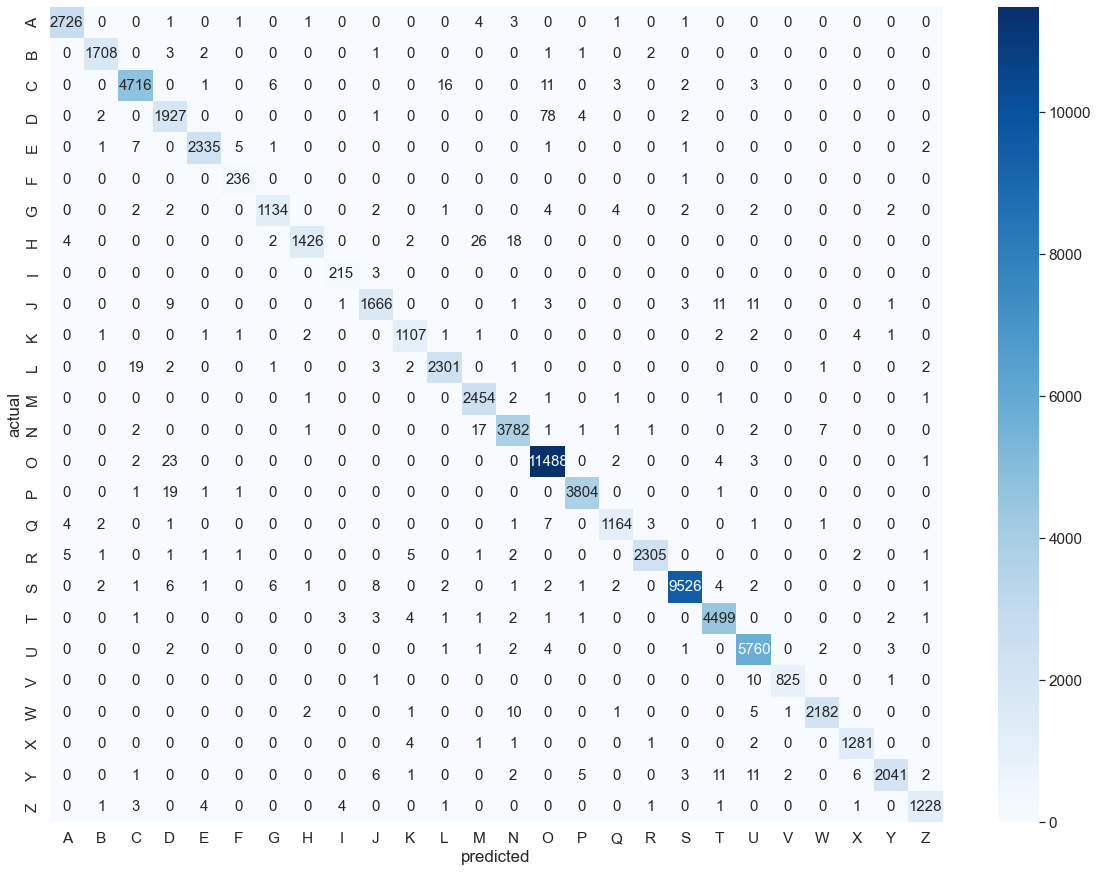

In [14]:
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

df_cm = pd.DataFrame(confusion, columns=np.unique(labels), index = np.unique(labels))
df_cm.index.name = 'actual'
df_cm.columns.name = 'predicted'
plt.figure(figsize = (20,15))
sn.set(font_scale=1.4) 
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 15}, fmt="d")

# How to interprete a confusion matrics

In [15]:
model.save("../-eng-alpha/saved_model/unet2-arct-model.h5")